In [1]:
from tqdm import tqdm
from torchvision import transforms
from utils.params import Params
import models.rcan
import models.ninab1
import models.ninab2
import models.edsr
import models.ninacustom
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
### CONFIG ###
channels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
model_files = ["ninab1_v10", "edsr_v3"]
path = "../Dataset/Raw/sentinel-2/06-001-0007/S2B_MSIL2A_20210911T184929_N0301_R113_T10SFG_20210911T214647.npy"

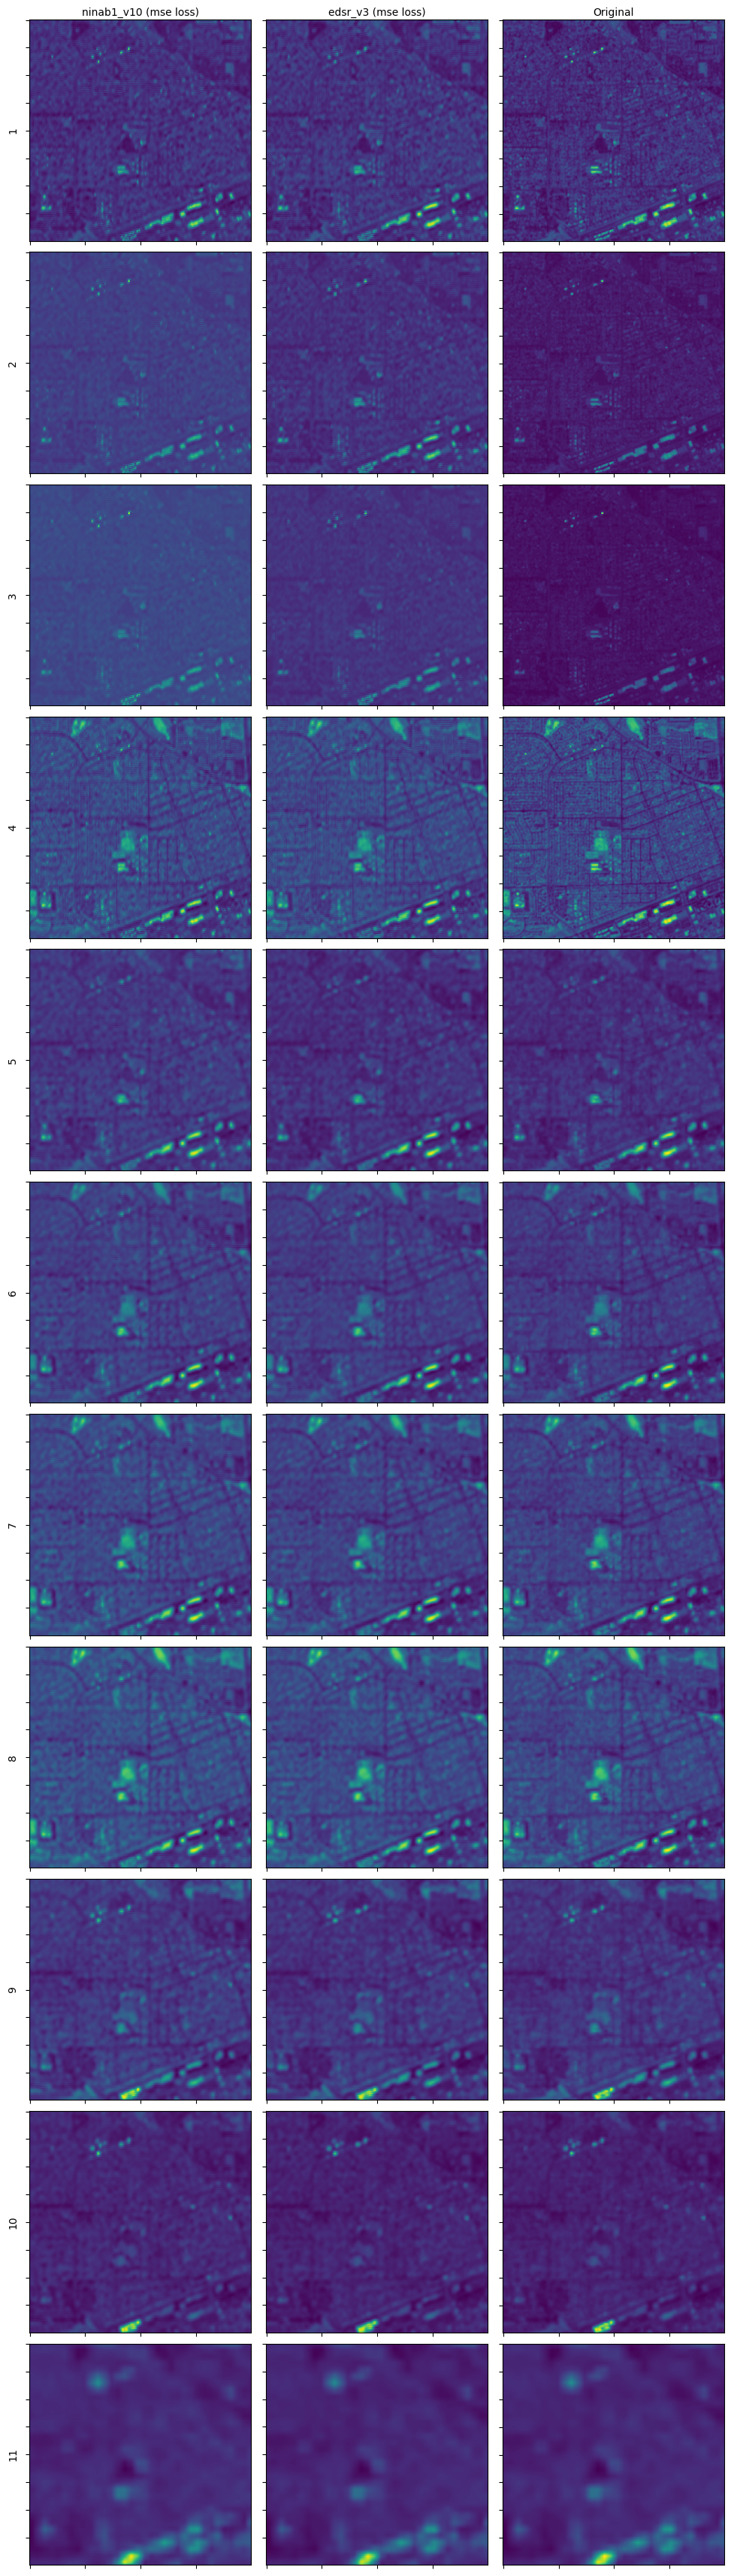

<Figure size 1200x4400 with 0 Axes>

In [10]:
#Setup
model_dict = {
    "edsr": models.edsr,
    "rcan": models.rcan,
    "ninab1": models.ninab1,
    "ninab2": models.ninab2,
    "ninacustom": models.ninacustom
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([
    transforms.ToTensor()])

#Load in and prepare the trained models
trained_models = [] #array of model objects
losses = []
for model_file in model_files:
    params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
    losses.append(params.loss_fn)
    model_type = model_file[:model_file.find("_")]
    model_shell = model_dict[model_type]
    trained_model = model_shell.net(params).to(device)
    trained_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt", map_location=device))
    trained_models.append(trained_model)

#Configure the subplots
plt.rcParams['figure.figsize'] = [4 * (len(trained_models) + 1), 4 * len(channels)]
fig, ax = plt.subplots(len(channels), len(trained_models)+1) #sharex=True, sharey=True)
plt.figure(dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
#fig.tight_layout()

im = np.load(path).astype("double")

#Now plot everything
for channel_index, channel in enumerate(channels):
    #Prepare input image
    hr = im[:, :, channel_index]
    hr = (hr - np.min(hr)) / (np.max(hr) - np.min(hr))
    input_hr = trans(hr).float()

    #Plot the SRs and the HR image
    for model_index, model in enumerate(trained_models):
        if model_index > 0:
            input_hr = input_hr.squeeze()
            input_hr = torch.stack((input_hr, input_hr, input_hr))
            input_hr = input_hr.unsqueeze(0)
        sr = model(input_hr).detach().numpy().reshape((3, 400, 400))[0, :, :]
        ax[channel_index][model_index].imshow(sr)

        #Set the model labels
        if channel_index == 0:
            ax[0][model_index].set_xlabel(model_files[model_index] + " (" + losses[model_index] + " loss)")
            ax[0][model_index].xaxis.set_label_position('top')

        #Clear tick labels for all plots
        ax[channel_index][model_index].set_xticklabels([])
        ax[channel_index][model_index].set_yticklabels([])

    #Plot the original
    ax[channel_index][len(trained_models)].imshow(hr)
    ax[channel_index][len(trained_models)].set_xticklabels([])
    ax[channel_index][len(trained_models)].set_yticklabels([])
    
    #Channel titles
    ax[channel_index][0].set_ylabel(channel)

ax[0][len(trained_models)].set_xlabel("Original")
ax[0][len(trained_models)].xaxis.set_label_position('top')

plt.show()
